In [42]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Initialize RNN

In [43]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [44]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    plasticity_bias = -0.45,
    narrow_search_factor=0.5, wide_search_factor=1.5,
    )

In [45]:
_, barcode_acts, _, _ = model.run_recurrent_r(place_inputs, 1.0)

In [46]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)

# Add predictive skew to RNN weights

In [47]:
identity = np.eye(model.N_bar)
total_delta = np.zeros((model.N_bar, model.N_bar))
n_shifts = 500 
gamma = 0.99
for s in range(1, n_shifts):
    shifted = np.roll(identity, shift=-(s+50), axis=0)
    delta = (gamma**s)*0.04*shifted
    model.J_xx += delta
    total_delta += delta.copy()

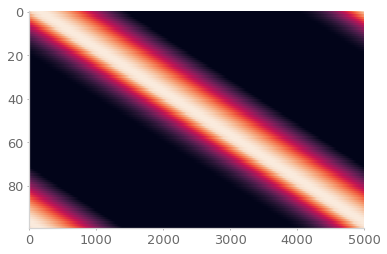

In [102]:
saved_J_xx = model.J_xx.copy()
model.J_xx = total_delta
_, pred_acts, _, _ = model.run_recurrent_r(place_inputs, 1.)
plt.figure()
plt.imshow(pred_acts, aspect='auto')
plt.show()
model.J_xx = saved_J_xx

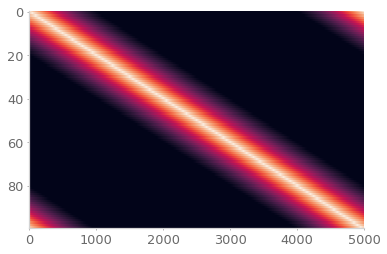

In [57]:
plt.figure()
plt.imshow(place_acts, aspect='auto')
plt.show()

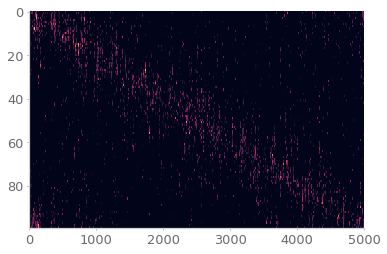

In [58]:
plt.figure()
plt.imshow(barcode_acts, aspect='auto')
plt.show()

In [84]:
_, acts, _, _ = model.run_recurrent_r(place_inputs, 0.3)

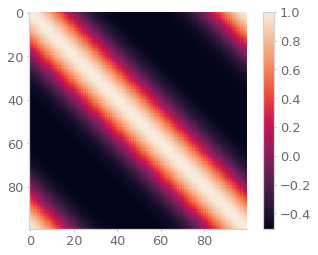

In [103]:
plt.figure()
plt.imshow(np.corrcoef(pred_acts))
plt.colorbar()
plt.show()

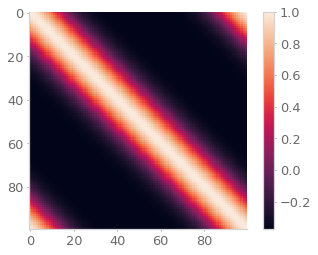

In [87]:
plt.figure()
plt.imshow(np.corrcoef(place_acts))
plt.colorbar()
plt.show()

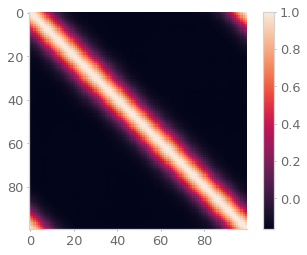

In [85]:
plt.figure()
plt.imshow(np.corrcoef(acts))
plt.colorbar()
plt.show()

In [122]:
_, final_barcode_acts, _, _ = model.run_recurrent_r(place_inputs, 1.0)

# Get projections for each value of r

In [ ]:
# Using corrcoef

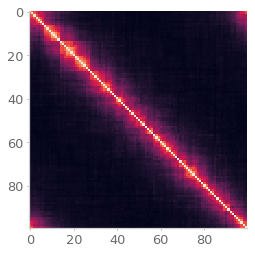

In [94]:
plt.figure()
plt.imshow(_act)
plt.show()

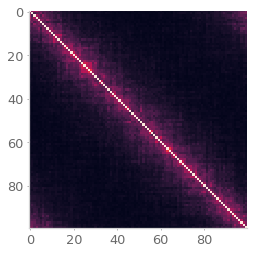

In [93]:
plt.figure()
plt.imshow(_bar)
plt.show()

# correlation with rows of correlation matrix

In [104]:
data = {
    'Projection': [],
    'r': [],
    'Mode': []
    }
for r in np.arange(0, 1.1, 0.1):
    _, acts, _, _ = model.run_recurrent_r(place_inputs, r)
    acts = acts - acts.mean()
    _bar = np.corrcoef(barcode_acts)
    _place = np.corrcoef(place_acts)
    _pred = np.corrcoef(pred_acts)
    _act = np.corrcoef(acts)
    
    for row in range(acts.shape[0]):
        data['Projection'].append(np.dot(_act[row], _place[row]))
        data['r'].append(r)
        data['Mode'].append('Place')

        data['Projection'].append(np.dot(_act[row], _pred[row]))
        data['r'].append(r)
        data['Mode'].append('Pred')

        data['Projection'].append(np.dot(_act[row], _bar[row]))
        data['r'].append(r)
        data['Mode'].append('Barcode')

In [105]:
df = pd.DataFrame(data)

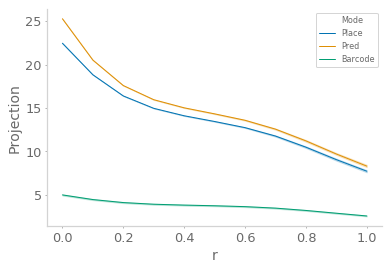

In [106]:
plt.figure()
sns.lineplot(x='r', y='Projection', hue='Mode', data=df)
plt.show()

# Correlation with correlation matrix

In [99]:
data = {
    'Projection': [],
    'r': [],
    'Mode': []
    }
for r in np.arange(0, 1.1, 0.1):
    _, acts, _, _ = model.run_recurrent_r(place_inputs, r)
    _bar = np.corrcoef(barcode_acts)
    _place = np.corrcoef(place_acts)
    _pred = np.corrcoef(pred_acts)
    _act = np.corrcoef(acts)
    
    data['Projection'].append(np.dot(_act.flatten(), _place.flatten()))
    data['r'].append(r)
    data['Mode'].append('Place')

    data['Projection'].append(np.dot(_act.flatten(), _pred.flatten()))
    data['r'].append(r)
    data['Mode'].append('Pred')

    data['Projection'].append(np.dot(_act.flatten(), _bar.flatten()))
    data['r'].append(r)
    data['Mode'].append('Barcode')

In [100]:
df = pd.DataFrame(data)

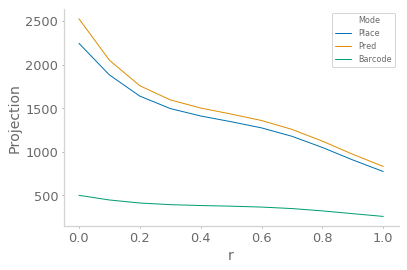

In [101]:
plt.figure()
sns.lineplot(x='r', y='Projection', hue='Mode', data=df)
plt.show()

# Correlation with rows of activity

In [127]:
data = {
    'Projection': [],
    'r': [],
    'Mode': []
    }
for r in np.arange(0, 1.1, 0.1):
    _, acts, _, _ = model.run_recurrent_r(place_inputs, r)
    
    for row in range(acts.shape[0]):
        _act = acts[row].copy()
        _act = _act - _act.mean()
        _act = _act/np.linalg.norm(_act)
        _bar = final_barcode_acts[row] / np.linalg.norm(barcode_acts[row])
        #_place = place_acts[row] / np.linalg.norm(place_acts[row])
        _pred = place_acts[(row+4)%num_states] / np.linalg.norm(place_acts[(row+3)%num_states])
        #_pred = pred_acts[row] / np.linalg.norm(pred_acts[row])
        
    
        #data['Projection'].append(np.dot(_act, _place))
        #data['r'].append(r)
        #data['Mode'].append('Place')

        data['Projection'].append(np.dot(_act, _pred))
        data['r'].append(r)
        data['Mode'].append('Pred')

        data['Projection'].append(np.dot(_act, _bar))
        data['r'].append(r)
        data['Mode'].append('Barcode')

In [128]:
df = pd.DataFrame(data)

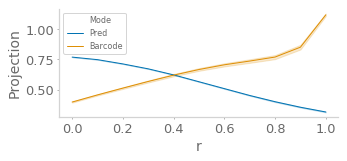

In [131]:
plt.figure(figsize=(5,2))
sns.lineplot(x='r', y='Projection', hue='Mode', data=df)
plt.show()

# Correlations with columns of activity

/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


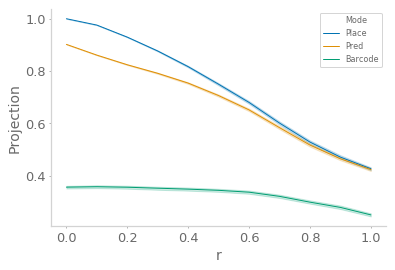

In [68]:
data = {
    'Projection': [],
    'r': [],
    'Mode': []
    }
for r in np.arange(0, 1.1, 0.1):
    _, acts, _, _ = model.run_recurrent_r(place_inputs, r)
    
    for col in range(acts.shape[1]):
        _act = acts[:, col].copy()
        _act = _act/np.linalg.norm(_act)
        _bar = barcode_acts[:,col] / np.linalg.norm(barcode_acts[:,col])
        _place = place_acts[:,col] / np.linalg.norm(place_acts[:,col])
        _pred = pred_acts[:,col] / np.linalg.norm(pred_acts[:,col])
    
        data['Projection'].append(np.dot(_act, _place))
        data['r'].append(r)
        data['Mode'].append('Place')

        data['Projection'].append(np.dot(_act, _pred))
        data['r'].append(r)
        data['Mode'].append('Pred')

        data['Projection'].append(np.dot(_act, _bar))
        data['r'].append(r)
        data['Mode'].append('Barcode')

df = pd.DataFrame(data)

# Make plots

plt.figure()
sns.lineplot(x='r', y='Projection', hue='Mode', data=df)
plt.show()